<a href="https://colab.research.google.com/github/douglasmmachado/Battery_SoC/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from scipy import stats

In [3]:
def verify_range(df):
  for column in df.columns:
    print(f'Column: {column}\n' +
          f'Max: {df[column].max()} \n' +
          f'Min: {df[column].min()}\n')

In [4]:
df_data = pd.read_csv('https://raw.githubusercontent.com/douglasmmachado/Battery_SoC/main/1%20-%20NN/data.csv')
verify_range(df_data)

#Presence of non valid values for all variables.

Column: current_measured
Max: 1.3708 
Min: -0.54385

Column: voltage_measured
Max: 4.1501 
Min: -30497.0

Column: voc
Max: 4.2 
Min: -2.4903

Column: rint
Max: 0.06135 
Min: 0.06

Column: zeta
Max: 100.0 
Min: -30498.0



In [5]:
#removing values below zero

for column in df_data.columns:

  df_data.drop(df_data[df_data[column] < 0].index, inplace = True)

verify_range(df_data)


Column: current_measured
Max: 1.3708 
Min: 0.63347

Column: voltage_measured
Max: 4.1501 
Min: 3.1217

Column: voc
Max: 4.2 
Min: 3.1779

Column: rint
Max: 0.061266 
Min: 0.06

Column: zeta
Max: 100.0 
Min: 0.054278



In [6]:
#Fill NaN with median
df_data = df_data.fillna(df_data.median())

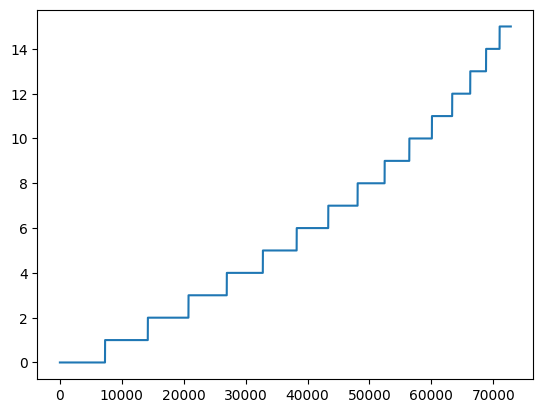

In [117]:
#Building y and X
I = np.array(df_data['current_measured'])
V = np.array(df_data['voltage_measured'])
Voc = np.array(df_data['voc'])
Rint = np.array(df_data['rint'])
Zeta = np.array(df_data['zeta'])
P = V*I #Feature 


#y = np.stack((Voc, Rint, Zeta), axis=1)
#X = np.stack((I, V, P), axis=1)

(72825,)

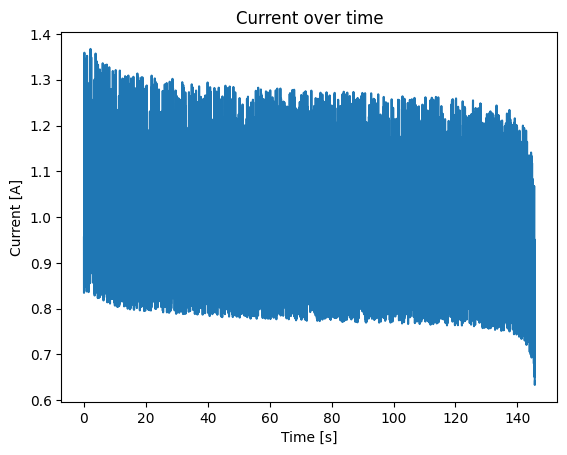

In [8]:
n = 7284 #End of first cycle
Te = 0.02
i_measured = X[:n,0]
time = np.arange(0,n,1)*Te 
plt.plot(time, i_measured)
plt.title('Current over time')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.show()

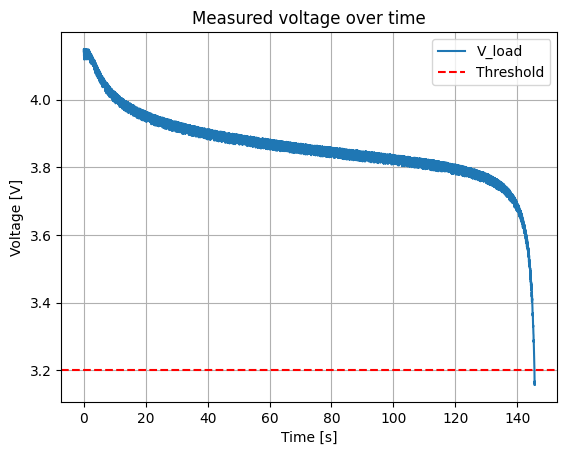

In [30]:
n = 7284 #End of first cycle
Te = 0.02
v_measured = X[:n,1]
time = np.arange(0,n,1)*Te 
plt.plot(time, v_measured,label= 'V_meas')
plt.title('Measured voltage over time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.axhline(y=3.2, color='r', linestyle='--', label = 'Threshold')
plt.legend()
plt.grid()
plt.show()

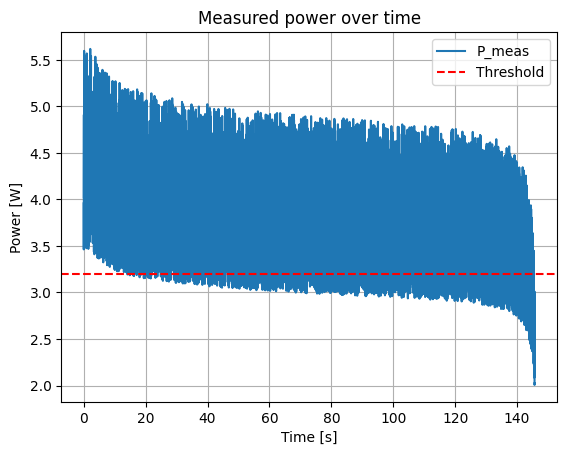

In [31]:
n = 7284 #End of first cycle
Te = 0.02
p_measured = X[:n,2]
time = np.arange(0,n,1)*Te 
plt.plot(time, p_measured,label= 'P_meas')
plt.title('Measured power over time')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()
plt.show()

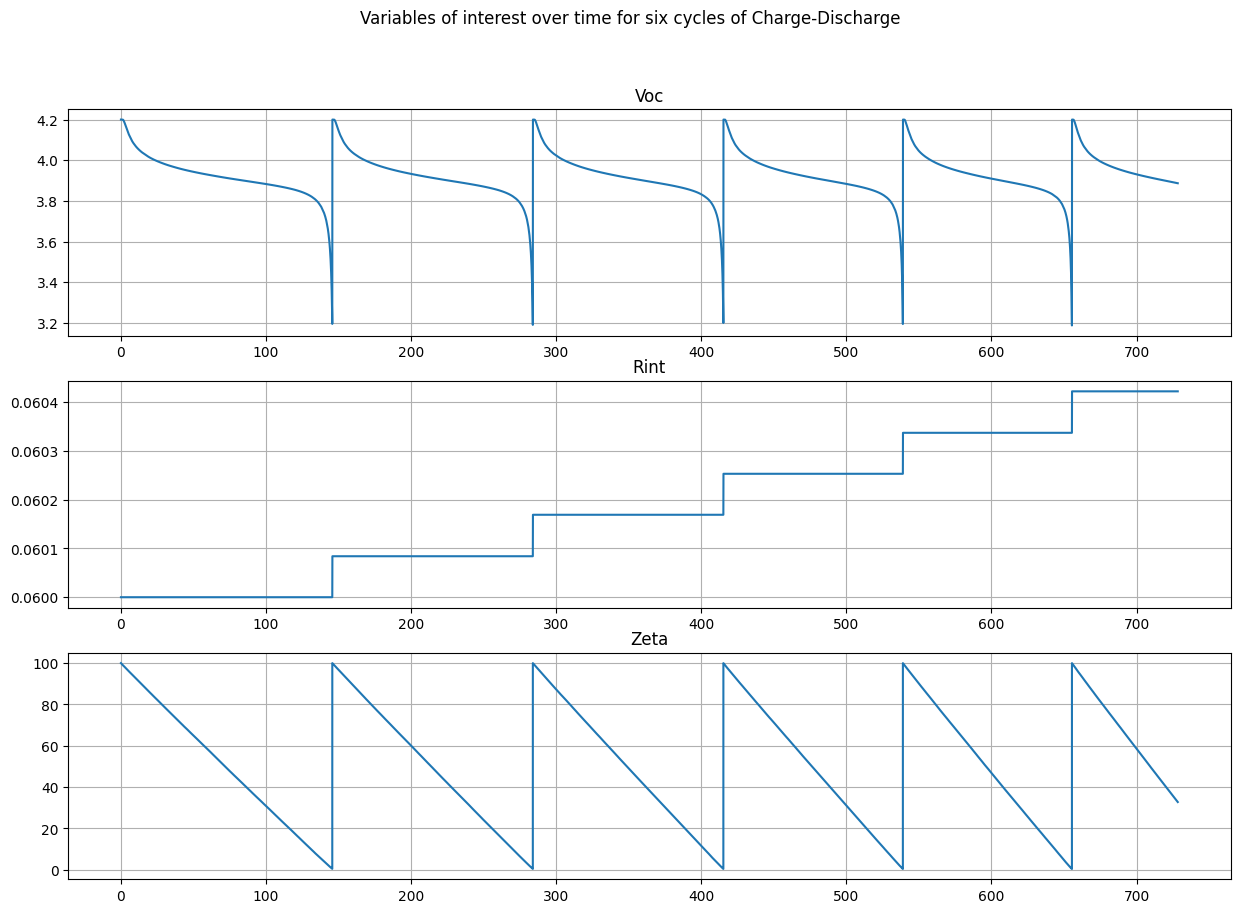

In [10]:
n = 7284 #End of first cycle


Te = 0.02
voc = y[:n*5,0]
rint = y[:n*5,1]
zeta = y[:n*5,2]
time = np.arange(0,n*5,1)*Te 


fig, axs = plt.subplots(3,1, figsize = (15,10))
fig.suptitle('Variables of interest over time for six cycles of Charge-Discharge')
axs[0].plot(time, voc)
axs[0].set_title('Voc')
axs[0].grid()

axs[1].plot(time, rint)
axs[1].set_title('Rint')
axs[1].grid()

axs[2].plot(time, zeta)
axs[2].set_title('Zeta')
axs[2].grid()

plt.show()

In [32]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)

dummy_regr.predict(X)

score = dummy_regr.score(X, y)
print(f'Score for dummy regressor: {score}')

'''
score(X, y[, sample_weight])
Return the coefficient of determination R^2 of the prediction.
'''


Score for dummy regressor: 0.0


'\nscore(X, y[, sample_weight])\nReturn the coefficient of determination R^2 of the prediction.\n'

In [100]:
#Using MLPRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle = False, test_size=0.33)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


regr = MLPRegressor(hidden_layer_sizes=(128, 64),
                    activation='relu',
                    alpha=0.0001,
                    random_state=1,
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose=True,
                    shuffle = False).fit(X_train_scaled, y_train)

Iteration 1, loss = 308.93162784
Iteration 2, loss = 25.41712605
Iteration 3, loss = 15.68676344
Iteration 4, loss = 11.81342584
Iteration 5, loss = 8.60187260
Iteration 6, loss = 5.78400303
Iteration 7, loss = 3.51473575
Iteration 8, loss = 1.97809469
Iteration 9, loss = 1.13294002
Iteration 10, loss = 0.70891373
Iteration 11, loss = 0.47166424
Iteration 12, loss = 0.32778953
Iteration 13, loss = 0.23553789
Iteration 14, loss = 0.21031737
Iteration 15, loss = 0.25556702
Iteration 16, loss = 0.56345432
Iteration 17, loss = 2.18711943
Iteration 18, loss = 2.21520197
Iteration 19, loss = 0.36454682
Iteration 20, loss = 0.15414934
Iteration 21, loss = 0.17938125
Iteration 22, loss = 0.23534888
Iteration 23, loss = 1.28421232
Iteration 24, loss = 2.83452782
Iteration 25, loss = 0.92969928
Iteration 26, loss = 0.16595325
Iteration 27, loss = 0.11988640
Iteration 28, loss = 0.11580419
Iteration 29, loss = 0.38671329
Iteration 30, loss = 2.22704076
Iteration 31, loss = 0.73304995
Iteration 32

In [101]:
y_pred = regr.predict(X_test_scaled)

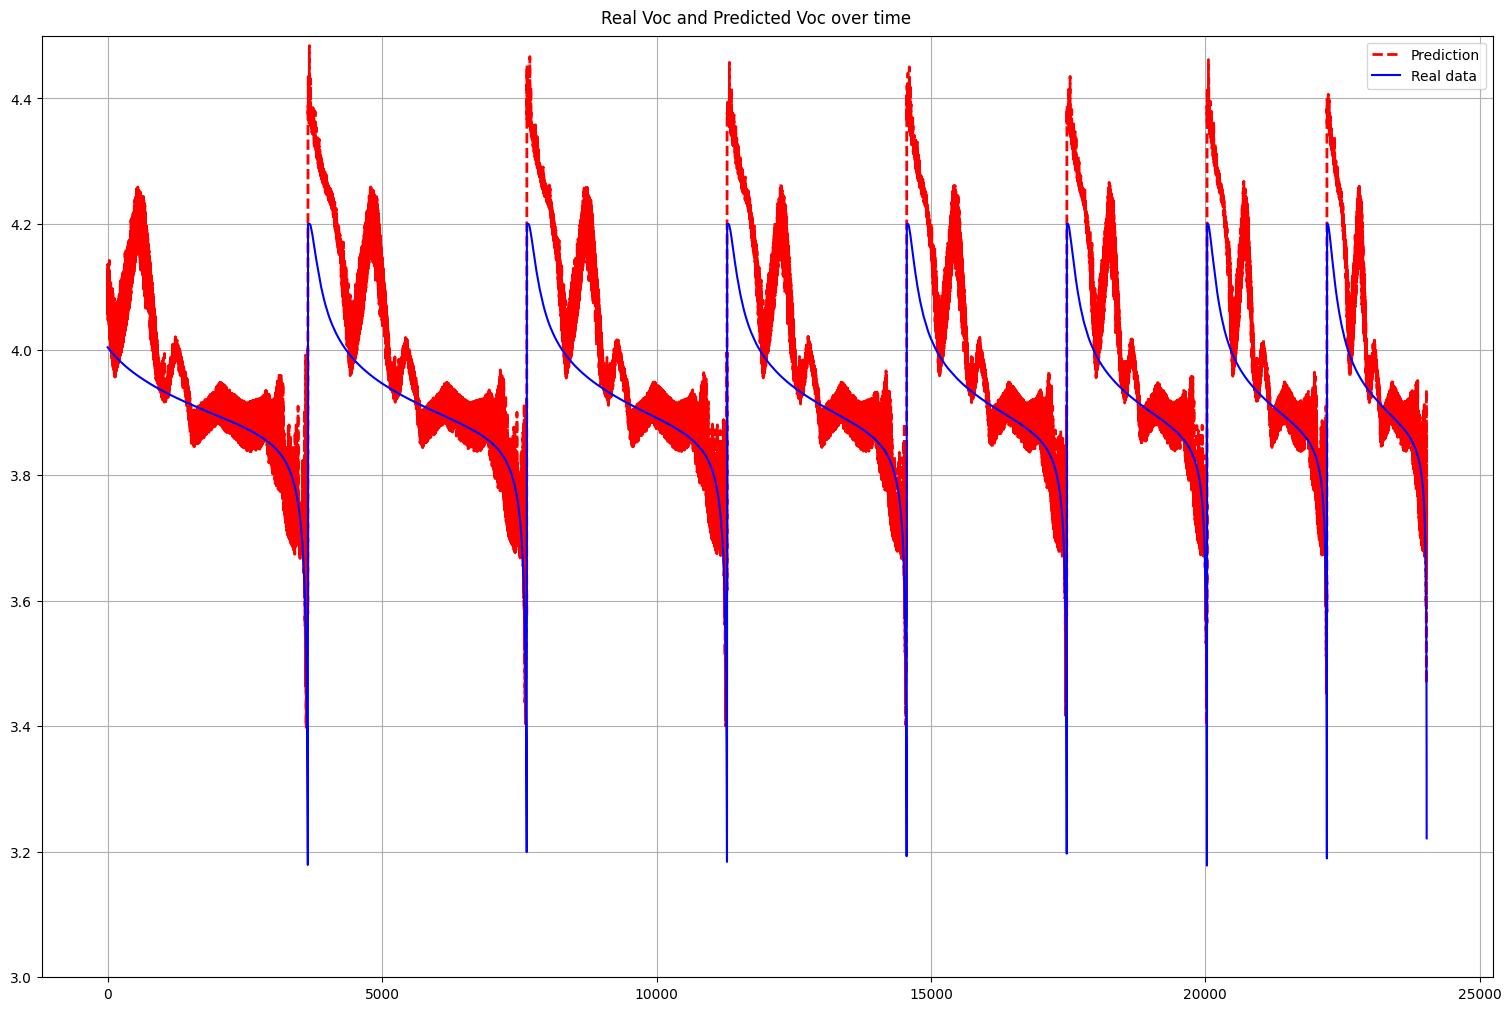

In [102]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Voc and Predicted Voc over time')
ax.plot(y_pred[:,0], 'r--', linewidth=2, label='Prediction')
ax.plot(y_test[:,0], '-b', label='Real data')
ax.grid()
plt.ylim([3,4.5])
ax.legend()

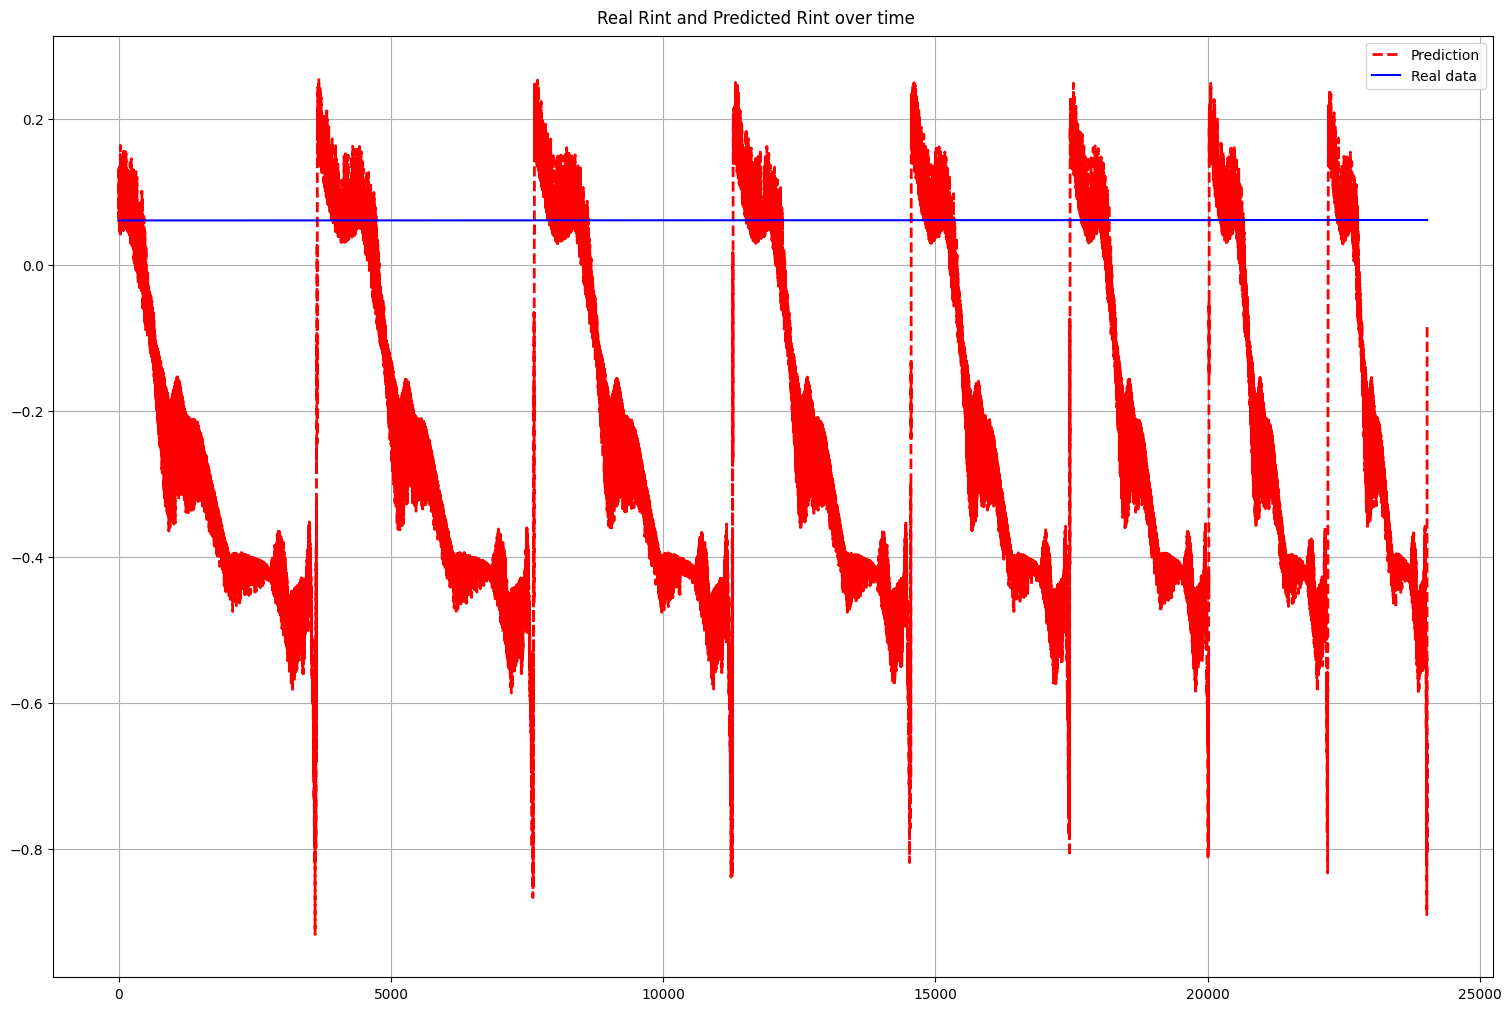

In [103]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Rint and Predicted Rint over time')
ax.plot(y_pred[:,1], 'r--', linewidth=2, label='Prediction')
ax.plot(y_test[:,1], '-b', label='Real data')
ax.grid()
#plt.ylim([3,4.5])
ax.legend()

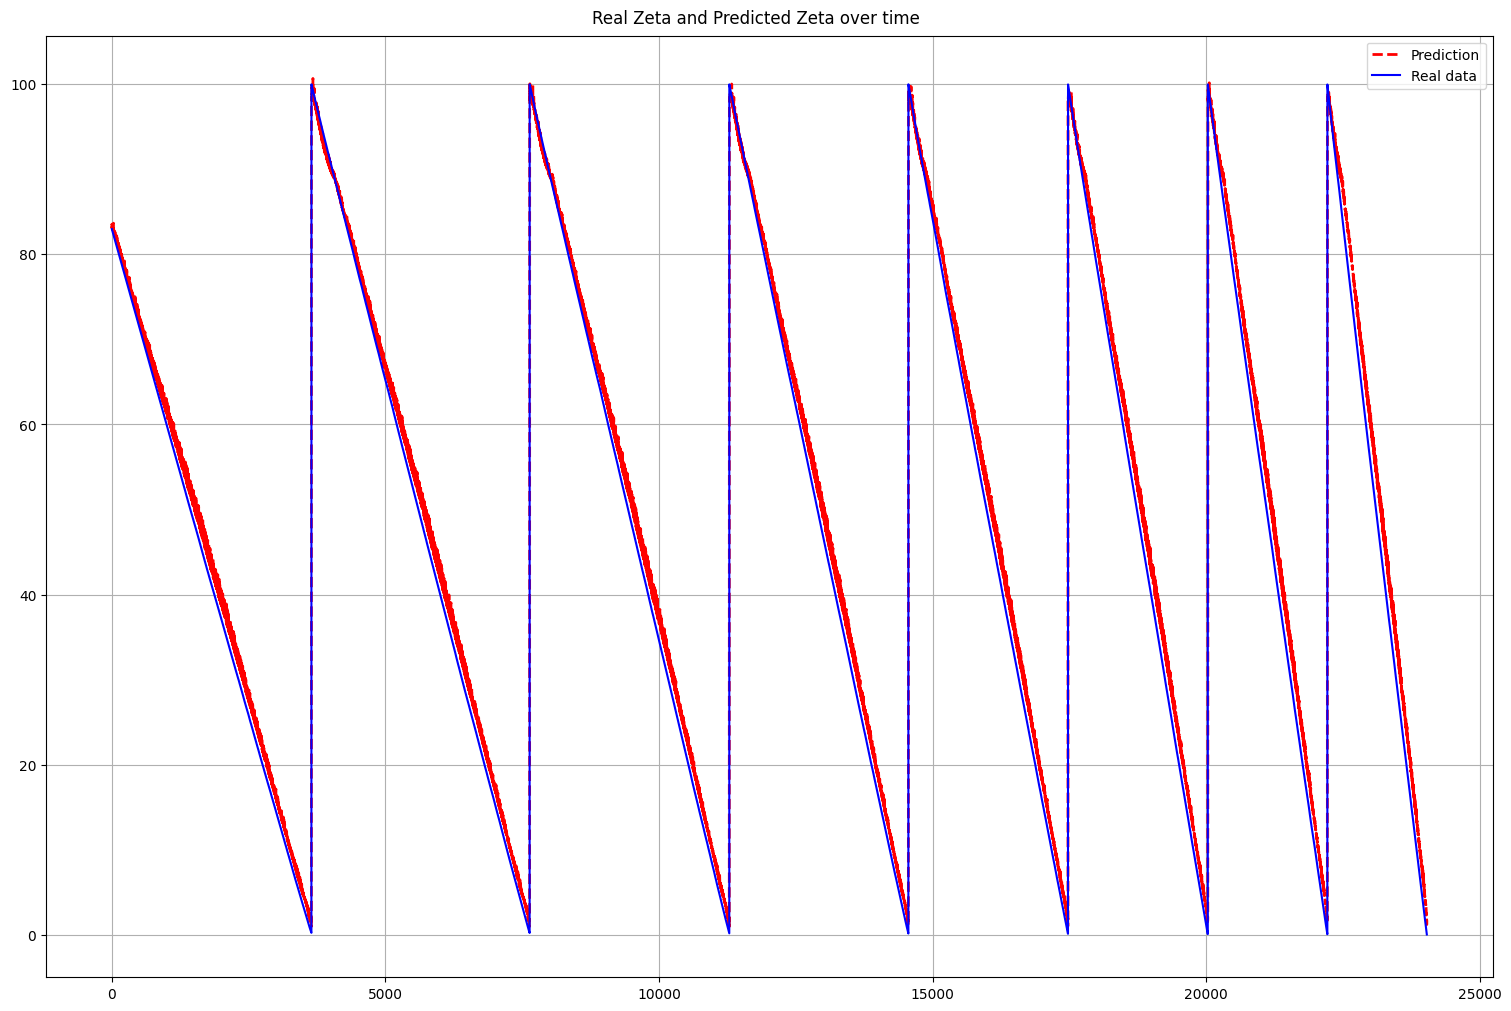

In [104]:
fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
fig.suptitle('Real Zeta and Predicted Zeta over time')
ax.plot(y_pred[:,2], 'r--', linewidth=2, label='Prediction')
ax.plot(y_test[:,2], '-b', label='Real data')
ax.grid()
#plt.ylim([3,4.5])
ax.legend()

In [105]:
'''
score(X, y[, sample_weight])
Return the coefficient of determination of the prediction.
The coefficient of determination R^2 is defined as (1 - u/v),
where u is the residual sum of squares ((y_true - y_pred)** 2).sum()
and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().
The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
A constant model that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.
'''
regr.score(X_test, y_test)

-1372145.7210119911

In [57]:
loss = regr.loss_curve_
plt.plot(loss)

AttributeError: ignored

In [56]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100,
                             max_depth=10,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='auto',
                             random_state=1)

# Train the model
regr.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = regr.predict(X_test_scaled)

# Evaluate the model
score = regr.score(X_test_scaled, y_test)
print("Regression score:", score)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Regression score: -3.514182281916856
